# Unit 3: Parameter Mapping Sonification

In [1]:
# setup, heading
import time, random, os
import numpy as np
import scipy, scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline

import sc3nb as scn

<IPython.core.display.Javascript object>

In [2]:
sc = scn.startup()  # optionally use argument sclangpath="/path/to/your/sclang"

Starting sclang...
Done.
Registering UDP callback...
Done.
Sclang started on non default port: 57121
Booting server...
Done.
"sc3nb started";
-> sc3nb started
sc3> sc3> 


### Definitions

* Definition: **Parameter Mapping Sonification (PMSon)** is
    * a **MAPPING** from data features
    * to **PARAMETERS** of a synthesizer
    * which in turn creates a **data-driven sound** (event or stream)
    * so that changes in data **systematically** result in sound changes.
    
* Think of it as the auditory analogue of scatter plots
    * where x,y,z, color, size, shape, texture are a mapping from data

* In most practical PMSon, a 1:1 mapping from a single feature to a single parameter is established
    * e.g. mapping an ECG signal (voltage) to frequency of a sine tone

* More generally, we can have:
    * 1:N mappings: a single variable affects various parameters, each with its own mapping function
    * N:1 mappings (called parameter nesting): a variable is used for various ends, e.g. time: temporal nesting
    * N:M mappings: mixtures of variables 

* PMSon is applicable to all auditory display tasks, the most relevant are:
    * data exploration, detecting previously unknown structure in the data
    * for process monitoring, detecting changes as they happen
    * summaries: creating overviews of whole data sets
    * rapid scanning: interactively brushing through data, e.g. in search of features
    * sensory substitution and augmentation

### Overview of typical PMSon parameters

**Amplitude --> Level**

* Signal amplitude (arb units, or V) affects **perceived loudness**
* Example: $s(t) = A(t)\cdot\sin(\omega t)$
* The amplitude is the factor $A$.
* If it is a function of time $A(t)$ it also models the so-called envelope (see below)
* Here is a set of tones with increasing amplitude

In [ ]:
%sc Synth.new("s1", ["freq", 400, "num", 1, "amp", 0.2])

In [ ]:
for v in range(0, 10):
    amp = scn.linlin(v, 0, 10, 0, 0.3)
    %sc Synth.new("s1", ["freq", 400, "num", 1, "amp", ^amp])
    time.sleep(0.3)

* obviously the perceived loudness does not seem to increase linearly
    * the first audible sound is not 1/10 of the level of the last
* the reason is the nonlinearity of perception
* a better mapping is logarithmic, e.g. using dbamp:

In [ ]:
for v in range(0, 10):
    db = scn.linlin(v, 0, 10, -50, 0)
    amp = scn.dbamp(db)
    %sc Synth.new("s1", ["freq", 400, "num", 1, "amp", ^amp])
    time.sleep(0.3)

* Note that amplitude (level) is ordinal with 0
* the mapping via dB has no zero, so can not be fully truthful
* Note that the perceived level depends strongly on the frequency

**Frequency --> pitch**

* Signal frequency (Hz) affects **pitch**
* Example: $s(t) = A(t)\cdot\sin(2\pi f t)$
* The frequency f is often constant in musical instruments
* If it is a function of time $f(t)$ it models chirps, vibrato etc
* Here is a set of tones with increasing frequency

In [ ]:
for v in range(0, 20):
    freq = scn.linlin(v, 0, 20, 100, 5000)
    %sc Synth.new("s1", ["freq", ^freq, "num", 1, "amp", 0.5])
    time.sleep(0.2)

* obviously the pitch does not seem to increase linearly
    * the first audible sound is not 1/10 the pitch of the last
* the reason is the nonlinearity of perception
* a better mapping is logarithmic, e.g. using midicps

In [ ]:
for v in range(0, 20):
    midi = scn.linlin(v, 0, 20, 43, 111)   # scn.cpsmidi(5000) approx 111
    freq = scn.midicps(midi)
    %sc Synth.new("s1", ["freq", ^freq, "num", 1, "amp", 0.5])
    time.sleep(0.2)

* Now the pitch is approximately equidistant
* Note the strong dependence of level on pitch
    * to compensate we can use the Fletcher-Munson curves compensation
    * in supercollider available via the AmpCompA.kr UGen

In [ ]:
# compare a sine without compensation
%sc s.scope
%sc { SinOsc.ar(MouseX.kr(50, 15000, 1)) * 0.2!2 }.play;

In [ ]:
# with one that uses amplitude compensation
%sc { var freq = MouseX.kr(50, 15000, 1); SinOsc.ar(freq) * 0.2 * AmpComp.kr(freq)!2 }.play;

**Frequency modulation --> Roughness**

and

**Frequency modulation --> Vibrato**
* these are two parameters: strength and rate

In [ ]:
%%sc
SynthDef("sfm", { | out=0, freq=400, amp=0.1, vibfreq=0, vibint=0, dur=0.5, pan=0 |
    var sig, env, mod;
    mod = SinOsc.ar(vibfreq, mul: vibint);
    sig = SinOsc.ar(freq+mod, mul: amp);
    env = Line.kr(1, 0, dur, doneAction: 2).pow(2);
    Out.ar(0, Pan2.ar(sig, pan, env));
}).add()

In [ ]:
%sc Synth.new(\sfm, [\dur, 1, \freq, 500, \vibfreq, 8, \vibint, 20])

In [ ]:
for v in range(0, 10):
    vibfreq = scn.linlin(v, 0, 10, 0, 40)
    vibint = 30
    %sc Synth.new("sfm", [\dur, 0.5, \freq, 400, \vibfreq, ^vibfreq, \vibint, ^vibint])
    time.sleep(0.6)

* Obviously, perception of fmod needs time
* at low frequencies it is perceived as vibrato
* at moderate frequencies it is perceived as roughness
* at high frequencies it turns into polyphony -> FM synthesis if vibfreq coupled to freq

In [ ]:
%sc FreqScope(400, 150)
%sc {SinOsc.ar(SinOsc.ar(MouseX.kr(0, 200), mul: 20, add: 400))}.play

**Spectral Centroid --> Sharpness**

In [ ]:
# the more harmonics we have the subjectively sharper the sound
%sc {Blip.ar(MouseX.kr(100,800), numharm: MouseY.kr(1, 50))}.play

**Amplitude envelope (ADSR) --> Temporal Gestalt** 

In [ ]:
%%sc
SynthDef("sadsr", { | out=0, freq=400, amp=0.1, gate=1, att=0, dec=1, sus=1, rel=1, pan=0 |
    var sig, env, mod;
    sig = SinOsc.ar(freq, mul: amp);
    env = EnvGen.kr(Env.adsr(att, dec, sus, rel, curve: -5), gate: gate, doneAction: 2);
    Out.ar(0, Pan2.ar(sig, pan, env));
}).add()

In [ ]:
%sc x = Synth.new("sadsr", [\att, 0.2, \dec, 1, \sus, 0.4, \rel, 0.7])  // note on -> start synth

In [ ]:
%sc x.set(\gate, 0)  // set note off -> proceed with the release phase of the ADSR

In [ ]:
for v in range(0, 10):
    att = scn.linlin(v, 0, 10, 0, 0.1)
    %sc x = Synth.new("sadsr", [\att, ^att, \dec, 0.1, \sus, 0.1, \rel, 0.1])
    time.sleep(0.1)
    %sc x.set(\gate, 0)
    time.sleep(0.3)

**Timbre**
* Defined as anything that makes a sound distinguishable from another sound of same level and pitch (ANSI)
* broadly: a mixture of qualities such as partials, spectral profile, particla envelopes

### Types of Mappings

* Let's assume we are given a data set with $N$ records of $d$ features each.
    * that gives a data table (matrix $X$) of $N$ rows and $d$ columns.
* Time can be one column, if the data are time-indexed
* Example of a non-time indexed data set
    * census data: (e.g. salary, size, weight, latitude and longitude of address)
    * iris data set: (150 plants characterized by geometric readings such as sepal size, petal length,...
* Example of a time-indexed data set:
    * EEG data: time stamp, voltage of various electrodes
    * rainfall episodes: onset, duration, amount (not equidistant)

**The main types of parameter mapping sonifications are:**
* Discrete PMSon (iris): for each row create a sound event, mapping features to parameters
* Continuous PMSon (building, ecg): modulate one (or more) continuous sound streams by data as they change
* Event-based PMSon (building, ecg): spawn events if certain conditions are met (e.g. maximum, sign change...)

Below we will see implementations of these types

**Mapping Function**
* linear: 

In [ ]:
# scn.linlin(v, src_from, src_to, dest_from, dest_to)
v = np.linspace(-10,10,1000)
plt.plot(v, scn.linlin(v, -5, 5, 20, 50)); plt.grid()

* logarithmic /exponential mapping

In [ ]:
# np.log(scn.linlin(v, src_from, src_to, dest_from, dest_to))
v = np.linspace(1,10,1000) # no zero crossing allowed
plt.plot(v, np.log(scn.linlin(v, 1, 10, 1, 50))); plt.grid()

In [ ]:
# np.exp(scn.linlin(v, src_from, src_to, dest_from, dest_to))
v = np.linspace(1, 10, 1000) # no zero crossing allowed
plt.plot(v, np.exp(scn.linlin(v, 1, 10, 1, 5))); plt.grid()

* custom, e.g. polynomial

In [ ]:
v = np.linspace(-1, 1, 1000) # zero crossing allowed
for o in [0.25, 0.5, 1, 2, 4, 10]:
    plt.plot(v, np.sign(v)*scn.linlin(abs(v), -1, 1, -1, 1)**o, label=f'order{o}'); 
plt.grid(); plt.legend();plt.axis('equal')

* clipping

In [ ]:
# scn.clip(v, min, max)
plt.plot(v, [scn.clip(x, -1, 0.5) for x in v]); plt.grid();

* data-driven mapping (linearized pdf)
    * here we estimate the cumulative density function from a given dataset cdf(x)
    * for any x we map linear interpolated cdf(x) to the destination range

In [ ]:
import scipy.interpolate
import scipy as sp
x = np.random.randn(400)
plt.plot(x, 0*x, '.', ms=10, alpha=0.01)
hc, hx = np.histogram(x, 30)
plt.plot(hx[:-1], hc/max(hc))
cx = np.sort(x)
cy = np.arange(len(cx))/float(len(cx))
plt.plot(cx, cy);
cdfn = sp.interpolate.interp1d(cx, cy)  # cdfn can be used as mapping function
plt.plot(v, cdfn(v)); plt.grid();

* 1:N-mapping, N:N-mapping, N:1-mapping
    * these are different mapping styles

### Load some data sets

In [3]:
# store them in a data set dictionary
ds = {}

def bpfilter(sig, lp=0.5, hp=50, sr=1000):
    f1 = lp / (sr/2)
    f2 = hp / (sr/2)
    b, a = scipy.signal.iirfilter(4, [f1, f2], btype='band', analog=False, ftype='butter')
    return scipy.signal.filtfilt(b, a, sig, method="gust", axis=0) 

#### ECG 

In [ ]:
draw = np.loadtxt("data/normalPTBDBpatient131s0273lre-1KHz.csv", delimiter=' ')
data = bpfilter(draw[:20000,0:6], 0.5, 40, sr=1000)
ds['ecg'] = data[:20000:10]
plt.plot(ds['ecg'][400:800]);

#### Iris data

In [ ]:
draw = np.loadtxt("data/iris.csv", delimiter=',')
ds['iris'] = draw[:, 1:]
d = ds['iris']
plt.scatter(d[:,2], d[:,3], c=d[:,4])
# plt.axis('equal');

#### Building data set

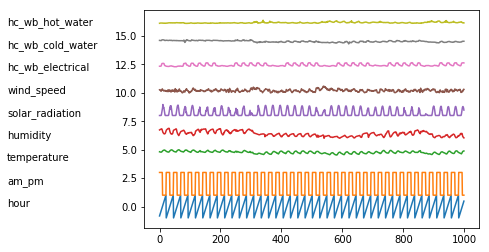

In [4]:
data = np.loadtxt("data/building.csv", delimiter=",", usecols=range(1,18))
ds['building'] = data
columns = [ "monday", "tuesday", "wednesday", "thursday", "friday","saturday", "sunday", 
"hour_from_noon", "hour", "am_pm", "temperature", "humidity", "solar_radiation", 
"wind_speed", "hc_wb_electrical", "hc_wb_cold_water", "hc_wb_hot_water"]
d = data.copy()
k=8
for i, r in enumerate(d[:1000,k:].T):
    plt.plot(r + 2*i, label=columns[k+i]);
    plt.text(-500, 2*i, columns[k+i])

In [ ]:
# PCA -- skip, not relevant
from sklearn.decomposition import PCA
data = ds['iris'][:,:4] # omit class label as input for PCA
pca = PCA(n_components=2)
dpca = pca.fit_transform(data)
plt.scatter(dpca[:,0], dpca[:,1], c=ds['iris'][:,4]);
pca.components_

### TimedQueue Basics

**Motivation**:
* for sonifications with precise timing, thousends of events need to be spawn at the exact time.
* doing this with bundles doesn't work as the OSC buffer of scsynth is limited
* it needs a TimedQueue where events can be added for time-precise dispatching
* a thread then simply checks what items are due and executes them
* using arbitrary functions as objects for the queue allows to use it both for sonification (e.g. sending OSC messages/bundles) and even visualization
* however, the functions should complete really quickly as otherwise the queue would run late and fail to process due events
* hence, it is the responsibility of the user to be careful
* if, however, longer programs are needed, they can be spawn as threads on execution
* The following demos illustrate the core functionality with console print and sound

In [ ]:
queue = scn.TimedQueue()

In [ ]:
import sys
def myfun(x):
    os.write(1, "{}\n".format(x).encode())
    sys.stderr.flush()
    
def myblip(freq):
    sc.msg("/s_new", ["s1", -1, 1, 0, "freq", freq, "num", 3])

In [ ]:
myfun(4)

In [ ]:
myblip(700)

In [ ]:
t0 = time.time()
for i in range(50):
    queue.put(t0+i*0.04, myblip, 800+1*7*i)
    queue.put(t0+i*0.04, myfun,  400+30*i)
print(time.time()-t0)

In [ ]:
queue.close()

### Simplest possible PMSon Example

In [5]:
queue = scn.TimedQueueSC(sc)

In [ ]:
d = ds['iris']
plt.scatter(d[:,3], d[:,1], c=[['r','g','b'][int(v)] for v in d[:,4]])
t0 = time.time()
delay = 0.2
for r in d:
    onset = scn.linlin(r[3],  0,   2.7,   0,   4)
    freq  = scn.linlin(r[1],  2,   4.5, 400, 800)    
    queue.put(t0+delay+onset, sc.msg, 
              ("/s_new", ["s1", -1, 1, 1, 'freq', freq, 'amp', 0.01, 'num', 1]))

**Remarks:**
* the mapping is manually chosen
    * ranges have to be manually specified
    * this makes experimentation tedious, as lots of details need to be adapted

### Column-aware mapping

The following function mapcol() looks up the min/max values in a column and maps linearly to a value range

In [6]:
def mapcol(row, stats, col, val_from, val_to):  # helper for mapping
    return scn.linlin(row[col], stats[col, 0], stats[col, 1], val_from, val_to)

For it we need an array stats with minimum and maximum value for all columns
* This is easily computed with python with the one liner:

      stats = np.vstack((np.min(data, 0), np.max(data, 0))).T

In [ ]:
data = ds['iris']
stats = np.vstack((np.min(data, 0), np.max(data, 0))).T
t0 = time.time()
delay = 0.2
for r in d:
    onset = mapcol(r, stats, 2,   0.0,  3.0)
    freq  = mapcol(r, stats, 3,   400, 1000)
    queue.put(t0 + delay + onset, sc.msg, ("/s_new", 
        ["s1", -1, 1, 1, 'freq', freq, 'amp', 0.1, 'num', 1]))

* now we can easily choose columns and parameter ranges

## Parameter Mapping Sonification Types

### Discrete Parameter Mapping

* we basically covered DPMSon above, here a snippet for your convenience with more mapping
* of course, you can create several synths in parallel and play polyphony etc.

In [ ]:
# queue = scn.TimedQueueSC(sc)  # needed only once, so don't re-evaluate if you have one already

In [ ]:
def mapcol(row, stats, col, val_from, val_to):  # helper for mapping
    return scn.linlin(row[col], stats[col, 0], stats[col, 1], val_from, val_to)

In [ ]:
data = ds['iris']
stats = np.vstack((np.min(data, 0), np.max(data, 0))).T
t0 = time.time()
delay = 0.2
for r in d:
    onset = mapcol(r, stats, 2,   0.0,   3.0)
    freq  = mapcol(r, stats, 3,   100,  1000)
    pan   = mapcol(r, stats, 1,    -1,     1)
    num   = mapcol(r, stats, 0,    1,     10)
    dur   = mapcol(r, stats, 4,    2,    0.3)
    queue.put(t0 + delay + onset, sc.msg, ("/s_new", 
        ["s1", -1, 1, 1, 'freq', freq, 'num', num, 'dur', dur, 'pan', pan]))

In [ ]:
plt.plot(d[:, 2], d[:,3], ".")

### Continuous Parameter Mapping

* For continuous PMSon, we first need to create a continuously playing synth

In [ ]:
%sc x = Synth.new("s2", [\amp, 0.04])

* We then modulate it with help of the (usually time-indexed) data values

In [ ]:
%sc x.set('freq', 250)

* Finally we stop the sound streams

In [ ]:
%sc x.free

* Mapping is similar to the discrete case, but beware that now values have temporal persistence
* this rules out some salient cues, such as attack time, or duration (which don't make sense with streams...)
* Here comes a full example for ECG data

In [ ]:
def mapcol(row, stats, col, val_from, val_to):  # helper for mapping
    return scn.linlin(row[col], stats[col, 0], stats[col, 1], val_from, val_to)

data = ds['ecg'][1000:2000]  # select only 10s starting from second 10
stats = np.vstack((np.min(data, 0), np.max(data, 0))).T
plt.plot(data[:1000,0]);

In [ ]:
t0 = time.time()
delay = 0.2

# instantiate synths
queue.put(t0+delay, sc.msg, ("/s_new", ["s2", 1234, 1, 1]))

# modulate with data while playing through time
for i, r in enumerate(data):
    onset = scn.linlin(i, 0, len(data), 0, 10.0)
    freq  = scn.midicps(mapcol(r, stats, 1,   60,  90))
    pan   = mapcol(r, stats, 2,    -1,     1)
    amp   = scn.dbamp(mapcol(r, stats, 3,    -30,  0))
    queue.put(t0 + delay + onset, sc.msg, ("/n_set", 
        [1234, 'freq', freq, 'num', 1, 'pan', pan, 'amp', amp]))

# shut down synth when finished
queue.put(t0 + delay + onset, sc.msg, ("/n_free", 1234))

### Event-based Parameter Mapping

* Event-based PMSon is more similar to discrete PMSon...
* but we do not sonify all data but only key moments (events)

# Challenge:
Create a PMSon of the building dataset where all relevant information can be discerned and understood. Variables:


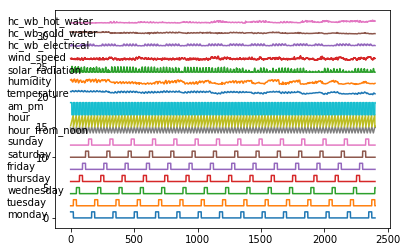

In [7]:
d = ds['building']
columns = [ "monday", "tuesday", "wednesday", "thursday", "friday","saturday", "sunday", 
"hour_from_noon", "hour", "am_pm", "temperature", "humidity", "solar_radiation", 
"wind_speed", "hc_wb_electrical", "hc_wb_cold_water", "hc_wb_hot_water"]
k=0
for i, r in enumerate(d[:2400,k:].T):
    plt.plot(r + 2*i, label=columns[k+i]);
    plt.text(-500, 2*i, columns[k+i])

In [8]:
%%sc 
SynthDef.new(\playbuf, {| out=0, bufnum=0, rate=1, amp=0.2, pan=0 |
    var sig;
    sig = PlayBuf.ar(1, bufnum, rate*BufRateScale.kr(bufnum), doneAction:2);
    Out.ar(0, Pan2.ar(sig, pan, amp));
}).add();

In [9]:
%sc b = Buffer.read(s, "samples/time-marker.wav")

In [12]:
%sc Synth.new(\playbuf, [\bufnum, b.bufnum, \amp, 1, \rate, 2.0])
bufnum = %scg b.bufnum

In [13]:
%%sc
SynthDef("elec", {| out=0, freq=100, amp=0.05, rate=500, rtime=0.1, pan=0 |
    var inp, sig;
    inp = Dust.ar(rate);
    sig = DynKlank.ar(`[freq*[8, 10.71, 11.53, 17.23], nil, rtime*[1, 1, 1, 1]], inp);
    Out.ar(out, Pan2.ar(sig, pan, amp));
}).add()

In [14]:
%sc x = Synth.new(\elec)

In [15]:
%sc x.set(\rate, 5)

In [16]:
%sc x.free

In [27]:
%%sc 
SynthDef("wind", {|out=0, cf=1000, rq=0.1, amp=0.1|
    Out.ar(out, BPF.ar(WhiteNoise.ar(amp), cf, rq))
}).add()   

In [28]:
%sc y = Synth.new("wind")

In [29]:
%sc y.free

In [26]:
t0 = time.time()
delay = 0.2

# instantiate synths
queue.put(t0, sc.msg, ("/s_new", ["elec", 1234, 1, 1, 'amp', 0.1]))
queue.put(t0, sc.msg, ("/s_new", ["s2", 1235, 1, 1, 'amp', 0.1]))
queue.put(t0, sc.msg, ("/s_new", ["wind", 1236, 1, 1, 'amp', 0.1]))

# modulate with data while playing through time
for i, r in enumerate(d[1000:1000+240]):
    onset = scn.linlin(i, 0, 240, 0, 10.0)
    rate  = scn.linlin(r[14], 0.3, 0.8, 1, 200)
    amp   = scn.linlin(r[14], 0.3,0.7, 0, 0.2)
    queue.put(t0 + delay + onset, sc.msg, ("/n_set", 
        [1234, 'rate', rate, 'amp', amp]))
    # midi = scn.linlin(r[10], 0.3, 1, 40, 47)
    # t_freq = scn.midicps( midi )
    t_freq = 100
    t_amp = scn.dbamp(scn.linlin(r[10], 0.3, 1, -50, -10))
    queue.put(t0 + delay + onset, sc.msg, ("/n_set", 
        [1235, 'freq', t_freq, 'amp', t_amp]))
    cf = scn.linlin(r[13], 0,1, 100, 5000)
    queue.put(t0 + delay + onset, sc.msg, ("/n_set", 
        [1236, 'cf', cf, 'amp', 1]))
    if r[8] == -1:  # that is midnight
        if r[5]==1 or r[6]==1: 
            rate = 2
        else:
            rate = 1
        queue.put(t0 + delay + onset, sc.msg, ("/s_new", 
            ["playbuf", -1, 1, 1, "bufnum", bufnum, "amp", 1, "rate", rate]))
        
# shut down synth when finished
queue.put(t0 + delay + onset+0.1, sc.msg, ("/n_free", 1234))
queue.put(t0 + delay + onset+0.1, sc.msg, ("/n_free", 1235))
queue.put(t0 + delay + onset+0.1, sc.msg, ("/n_free", 1236))

In [ ]:
plt.plot(d[:2400,10])